
## 02. Pseudoinverse solution from linear measurements



#### Load a batch of images



Shape of input images: torch.Size([7, 1, 64, 64])


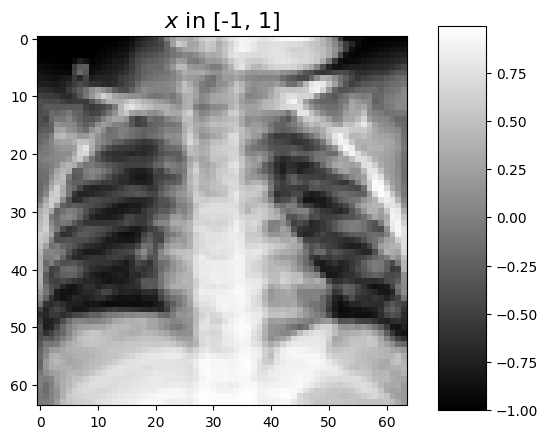

In [1]:

import os
from spyrit.misc.statistics import transform_gray_norm
import torchvision
import torch
from spyrit.misc.disp import imagesc

h = 64  # image size hxh
i = 0  # Image index (modify to change the image)
spyritPath = os.getcwd()
imgs_path = os.path.join(spyritPath, "../images")


# transform for original images to normalized grayscale image tensors
transform = transform_gray_norm(img_size=h)
dataset = torchvision.datasets.ImageFolder(root=imgs_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=7)

x, _ = next(iter(dataloader))
print(f"Shape of input images: {x.shape}")

# Select image
x = x[i : i + 1, :, :, :]
x = x.detach().clone()
b, c, h, w = x.shape

# plot
x_plot = x.view(-1, h, h).cpu().numpy()
imagesc(x_plot[0, :, :], r"$x$ in [-1, 1]")

## Define a measurement operator



In [3]:
from spyrit.misc.walsh_hadamard import walsh2_matrix
import numpy as np

F = walsh2_matrix(h)
F = np.where(F > 0, F, 0)


To keep the low-frequency Hadamard coefficients, we choose a sampling map
with ones in the top left corner and zeros elsewhere.



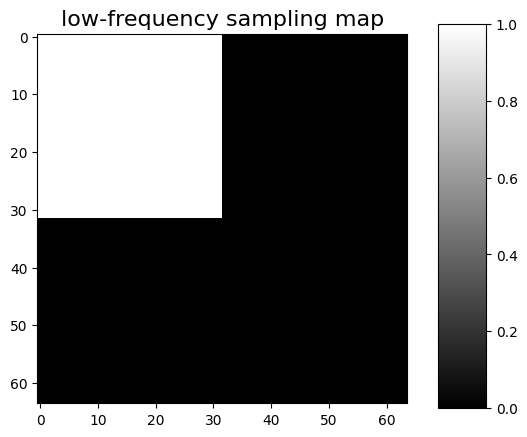

In [4]:
import math

und = 4  # undersampling factor
M = h**2 // und  # number of measurements (undersampling factor = 4)

Sampling_map = np.ones((h, h))
M_xy = math.ceil(M**0.5)
Sampling_map[:, M_xy:] = 0
Sampling_map[M_xy:, :] = 0

imagesc(Sampling_map, "low-frequency sampling map")

After permutation of the full Hadamard matrix, we keep only its first
:attr:`M` rows



In [5]:
from spyrit.misc.sampling import Permutation_Matrix

Perm = Permutation_Matrix(Sampling_map)
F = Perm @ F
H = F[:M, :]

print(f"Shape of the measurement matrix: {H.shape}")

Shape of the measurement matrix: (1024, 4096)


Then, we instantiate a :class:`spyrit.core.meas.Linear` measurement operator



In [6]:
from spyrit.core.meas import Linear
meas_op = Linear(H, pinv=True)

# noiseless case
from spyrit.core.noise import NoNoise

noise = NoNoise(meas_op)

# Simulate measurements
y = noise(x.view(b * c, h * w))
print(f"Shape of raw measurements: {y.shape}")

Shape of raw measurements: torch.Size([1, 1024])


Shape of the raw measurement image: (64, 64)


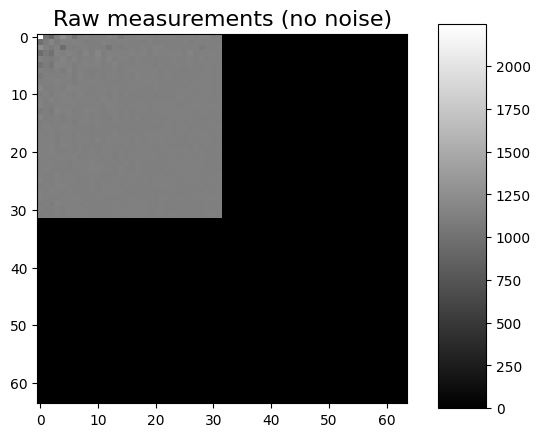

In [7]:
# plot
from spyrit.misc.sampling import meas2img

y_plot = y.detach().numpy().squeeze()
y_plot = meas2img(y_plot, Sampling_map)
print(f"Shape of the raw measurement image: {y_plot.shape}")

imagesc(y_plot, "Raw measurements (no noise)")

We now compute and plot the preprocessed measurements corresponding to an
image in [-1,1].



Shape of the preprocessed measurements: torch.Size([1, 1024])
Shape of the preprocessed measurement image: (64, 64)


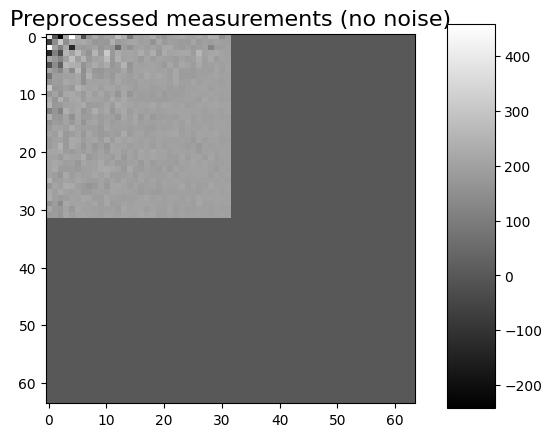

In [8]:
from spyrit.core.prep import DirectPoisson

prep = DirectPoisson(1.0, meas_op)  # "Undo" the NoNoise operator

m = prep(y)
print(f"Shape of the preprocessed measurements: {m.shape}")

# plot
m_plot = m.detach().numpy().squeeze()
m_plot = meas2img(m_plot, Sampling_map)
print(f"Shape of the preprocessed measurement image: {m_plot.shape}")

imagesc(m_plot, "Preprocessed measurements (no noise)")

## Pseudo inverse



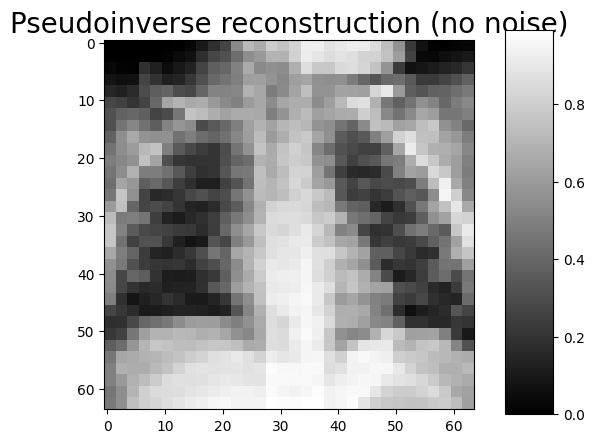

In [9]:
from spyrit.core.recon import PseudoInverse

# Pseudo-inverse reconstruction operator
recon_op = PseudoInverse()

# Reconstruction
x_rec = recon_op(y, meas_op)

# plot
x_plot = x_rec.squeeze().view(h, h).cpu().numpy()
imagesc(x_plot, "Pseudoinverse reconstruction (no noise)", title_fontsize=20)

#### PinvNet Network
* Then computing the pseudoinverse solution, which is fed to a neural
networker denoiser. 
* To compute the pseudoinverse solution , the denoiser
can be set to the identity operator



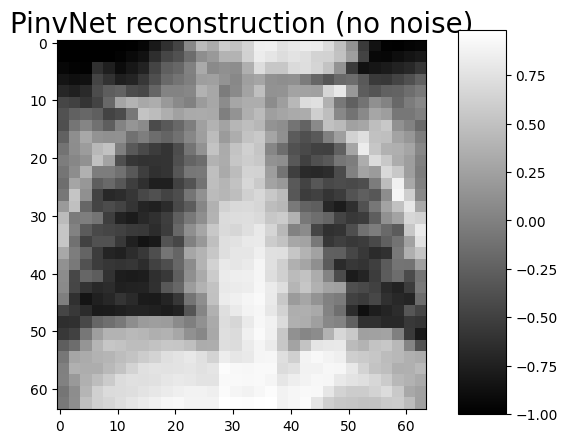

In [10]:
from spyrit.core.recon import PinvNet

pinv_net = PinvNet(noise, prep, denoi=torch.nn.Identity())
pinv_net = PinvNet(noise, prep)
# reconstruct image
x_rec = pinv_net.reconstruct(y)
# plot
x_plot = x_rec.squeeze().cpu().numpy()
imagesc(x_plot, "PinvNet reconstruction (no noise)", title_fontsize=20)

In [16]:
# #### Poisson-corrupted measurement



# alpha = 10  # maximum number of photons in the image

# from spyrit.core.noise import Poisson
# from spyrit.misc.disp import imagecomp

# noise = Poisson(meas_op, alpha)
# prep = DirectPoisson(alpha, meas_op)  # To undo the "Poisson" operator
# pinv_net = PinvNet(noise, prep)

# x_rec_1 = pinv_net(x)
# x_rec_2 = pinv_net(x)
# print(f"Ground-truth image x: {x.shape}")
# print(f"Reconstructed x_rec: {x_rec.shape}")

# # plot
# x_plot_1 = x_rec_1.squeeze().cpu().numpy()
# x_plot_1[:2, :2] = 0.0  # hide the top left "crazy pixel" that collects noise
# x_plot_2 = x_rec_2.squeeze().cpu().numpy()
# x_plot_2[:2, :2] = 0.0  # hide the top left "crazy pixel" that collects noise
# imagecomp(x_plot_1, x_plot_2, "Pseudoinverse reconstruction", "Noise #1", "Noise #2")